In [1]:
!pip install earthpy gdal seaborn geopandas rasterio lightgbm

     |████████████████████████████████| 1.4MB 4.5MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 972kB 23.8MB/s 
     |████████████████████████████████| 18.1MB 231kB/s 
     |████████████████████████████████| 10.9MB 43.9MB/s 
     |████████████████████████████████| 14.8MB 321kB/s 
  Created wheel for earthpy: filename=earthpy-0.9.2-cp36-none-any.whl size=1365088 sha256=56c04d171f47bacadaada586b9329f18e94b0a4d7a3ac2010ebafdbb5b1260cd
  Stored in directory: /root/.cache/pip/wheels/27/f9/a5/026bb95ef7b12f9343b842da6897b4001c5b902550095cbbbe
Successfully built earthpy


In [2]:
from glob import glob
import os
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.colors import ListedColormap
from matplotlib import colors
import matplotlib as mpl
import seaborn as sns

import rasterio as rio
from rasterio.plot import plotting_extent
from rasterio.plot import show
from rasterio.plot import reshape_as_raster, reshape_as_image

import gdal 

import geopandas as gpd
from shapely.geometry import mapping, box

import pandas as pd

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# sns.set_style('white')
# sns.set(font_scale=1.5)      

In [3]:
%cd /content/drive/My Drive/NASA SPACE APP

/content/drive/.shortcut-targets-by-id/103/NASA SPACE APP


In [4]:
def show_band(img, title='', size=(6,6), cmap='viridis'):
  # colors = ["g", "yellowgreen",
  #             "peachpuff", "coral", "maroon"]
  # cmap = ListedColormap(colors)
  print(title+' Shape: ', img.shape)
  fig = plt.figure(figsize=size)
  plt.imshow(img.reshape(img.shape[0], img.shape[1]), cmap= cmap)
  plt.axis('off')
  plt.colorbar()
  plt.title(title)
  plt.show()


In [5]:
ls

 AF_CliP_Tiff/                           'FLOOD EXTRA'/
'After Flood_Sentinel'/                   flood_model.txt
 AlgaeBloomBands/                        'flood shp'/
'Automated Detection of Hazards.gsheet'   harsha_lake/
'Before Flood_sentinel'/                 'NoteBook : Algae bloom Ujala'/
 BF_CliP_Tiff/                           'Notebook : Fire Gaurav'/
'Bihar Flood'/                           'Notebook : Flood Syam Juyee'/
 flood_dataset.csv                        Resources/
'FLOOD DAY'/                             'System Architecture.gdoc'
 flood-detection/


## prepare Data

In [6]:
with rio.open('Bihar Flood/After Flood_sentinel/GRANULE/L1C_T46REQ_A016847_20200528T041843/IMG_DATA/T46REQ_20200528T041549_B03.jp2') as f1_af:
  b3_af = f1_af.read()

with rio.open('Bihar Flood/After Flood_sentinel/GRANULE/L1C_T46REQ_A016847_20200528T041843/IMG_DATA/T46REQ_20200528T041549_B08.jp2') as f2_af:
  b8_af = f2_af.read()

with rio.open('Bihar Flood/After Flood_sentinel/NDWI_after_flood.tiff') as f3_af:
  ndwi = f3_af.read()

with rio.open('Bihar Flood/After Flood_sentinel/flood_GT.tiff') as f4_gt:
  gt = f4_gt.read()

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:221: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Green Band(B3) Shape:  (10980, 10980)


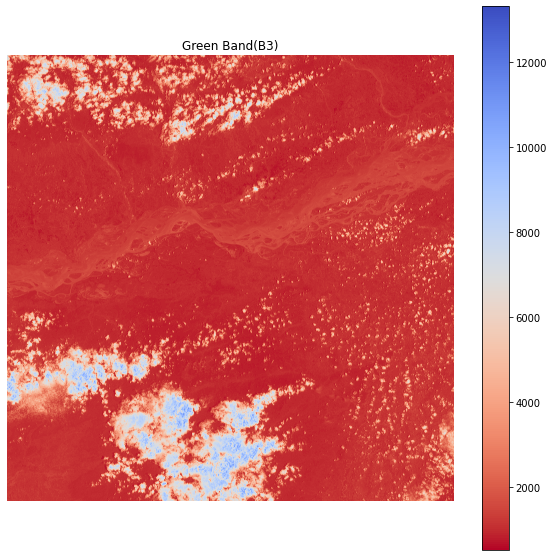

NIR Band(B8) After Floods Shape:  (10980, 10980)


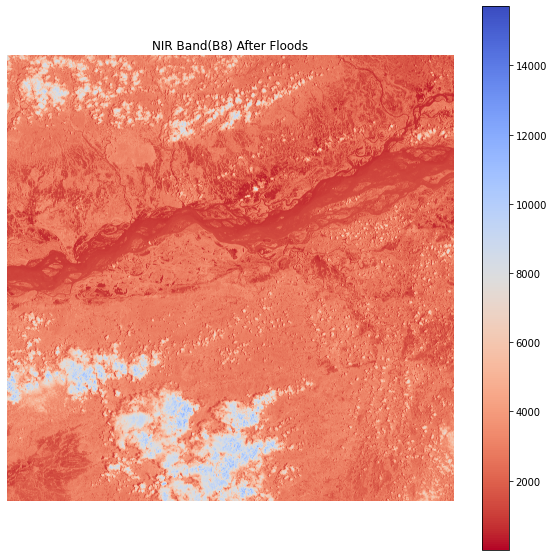

NDWI After Floods Shape:  (10980, 10980)


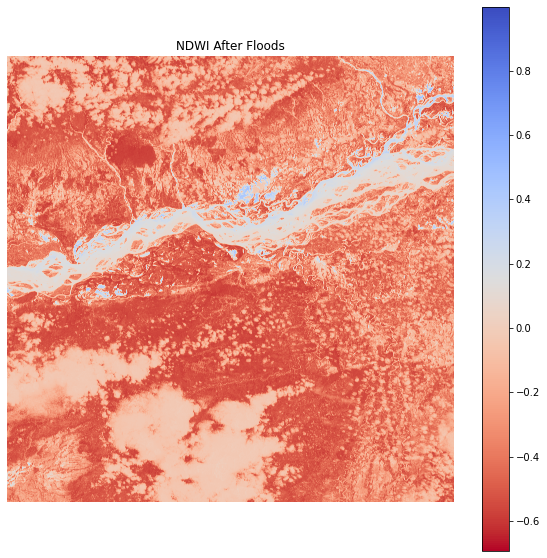

Ground Truth Shape:  (10980, 10980)


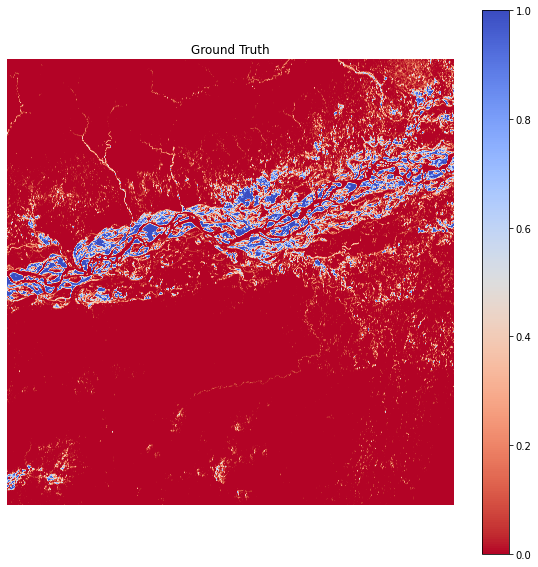

In [7]:
show_band(b3_af.reshape(b3_af.shape[1:]), title='Green Band(B3)', size=(10,10), cmap='coolwarm_r')

show_band(b8_af.reshape(b8_af.shape[1:]), title='NIR Band(B8) After Floods', size=(10,10), cmap='coolwarm_r')

show_band(ndwi.reshape(ndwi.shape[1:]), title='NDWI After Floods', size=(10,10), cmap='coolwarm_r')

show_band(gt.reshape(gt.shape[1:]), title='Ground Truth', size=(10,10), cmap='coolwarm_r')

## Calculate Coordinate to crop Image

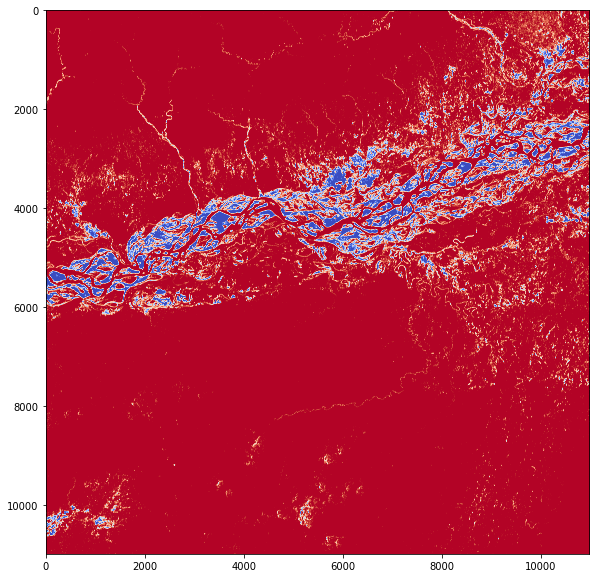

In [8]:
plt.figure(figsize=(10, 10))
plt.imshow(gt.reshape(gt.shape[1:]), cmap='coolwarm_r')

#### Manually, calculate the coordinates to crop the image, the coordinate may vary w.r.t to the data.

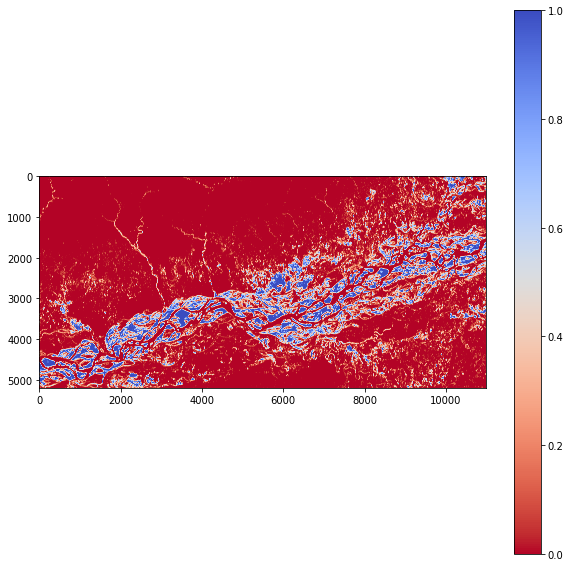

In [9]:
# Change the coordinated here to crop the data...

x1, x2, y1, y2 = (800, 6000, 0, 10980)

data = gt.reshape(gt.shape[1:])[x1:x2, y1:y2]
# Plot the cropped data

plt.figure(figsize=(10, 10))
plt.imshow(data, cmap='coolwarm_r')
plt.colorbar()
plt.show()

In [10]:
data.shape

(5200, 10980)

The decided coordinates are (800, 6000, 0, 10980)

Ground Truth Shape is (5200, 10980)

## Cerate a dataset acoording to the cropped data...

In [11]:
sz =data.shape

df = pd.DataFrame(columns=['b3', 'b8', 'ndwi', 'groundTruth'])

df['b3'] = b3_af.reshape(b3_af.shape[1:])[x1:x2, y1:y2].astype('float32').ravel()

df['b8'] = b8_af.reshape(b8_af.shape[1:])[x1:x2, y1:y2].astype('float32').ravel()

df['ndwi'] = ndwi.reshape(ndwi.shape[1:])[x1:x2, y1:y2].ravel()

df['groundTruth'] = gt.reshape(gt.shape[1:])[x1:x2, y1:y2].ravel().astype(int)

In [12]:
df.head()

,b3,b8,ndwi,groundTruth
0,998.0,3299.0,-0.535490,0
1,1052.0,3397.0,-0.527085,0
2,1012.0,2866.0,-0.478081,0
3,994.0,2802.0,-0.476291,0
4,1007.0,3067.0,-0.505646,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57096000 entries, 0 to 57095999
Data columns (total 4 columns):
 #   Column       Dtype  
---  ------       -----  
 0   b3           float32
 1   b8           float32
 2   ndwi         float32
 3   groundTruth  int64  
dtypes: float32(3), int64(1)
memory usage: 1.1 GB


In [14]:
df.describe()

,b3,b8,ndwi,groundTruth
count,5.709600e+07,5.709600e+07,5.709600e+07,5.709600e+07
mean,6.751696e+02,1.273318e+03,-2.437880e-01,1.288887e-01
std,1.085944e+03,1.479719e+03,2.254509e-01,3.350767e-01
min,5.230000e+02,1.000000e+00,-6.840891e-01,0.000000e+00
25%,9.650000e+02,1.375000e+03,-4.752528e-01,0.000000e+00
50%,1.089000e+03,2.433000e+03,-3.024390e-01,0.000000e+00
75%,1.326000e+03,3.101000e+03,-7.282773e-02,0.000000e+00
max,1.331600e+04,1.571300e+04,9.969088e-01,1.000000e+00


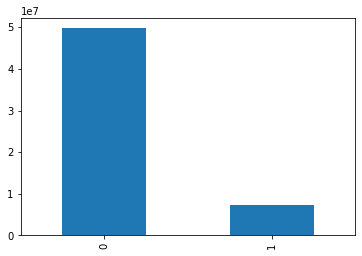

In [15]:
df.groundTruth.value_counts().plot(kind = 'bar')
plt.show()

In [ ]:
# df.to_csv('flood_dataset.csv', index=False)

## Ml Model

we are using **lightbgm**

In [16]:
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns

In [17]:
# df = pd.read_csv('flood_dataset.csv')

In [18]:
df.head()

,b3,b8,ndwi,groundTruth
0,998.0,3299.0,-0.535490,0
1,1052.0,3397.0,-0.527085,0
2,1012.0,2866.0,-0.478081,0
3,994.0,2802.0,-0.476291,0
4,1007.0,3067.0,-0.505646,0


In [19]:
x = df.iloc[:, :-1].values

y = df.iloc[:, -1].values

print(f'Data Shape: {x.shape}\nLabel Shape:{y.shape}')

Data Shape: (57096000, 3)
Label Shape:(57096000,)


In [20]:
#scaling the features using Standard Scaler

sc=StandardScaler()

sc.fit(x)

X=sc.fit_transform(x)

In [21]:
#train_test_split 

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=11, stratify = y)

In [22]:
print(f'X_train Shape:{X_train.shape}\nX_test Shape:{X_test.shape}\ny_train Shape:{y_train.shape}\ny_test Shape:{y_test.shape}')

X_train Shape:(42822000, 3)
X_test Shape:(14274000, 3)
y_train Shape:(42822000,)
y_test Shape:(14274000,)


In [23]:
#converting the dataset into proper LGB format 

d_train=lgb.Dataset(X_train, label=y_train)

In [24]:
#Specifying the parameter

params = {}
params['learning_rate']=0.035
params['boosting_type']='gbdt' #GradientBoostingDecisionTree
params['objective']='binary' #Binary target feature
params['metric']='binary_logloss' #metric for binary classification
params['max_depth']=18

In [25]:
#train the model 

clf = lgb.train(params, d_train, 80)

In [26]:
#prediction on the test set

y_pred = clf.predict(X_test)

In [27]:
# if>=0.5 ---> 1
# else ---->0
#rounding the values

y_pred = y_pred.round(0)

#converting from float to integer
y_pred=y_pred.astype(int)

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97  12434243
           1       0.76      0.80      0.78   1839757

    accuracy                           0.94  14274000
   macro avg       0.87      0.88      0.87  14274000
weighted avg       0.94      0.94      0.94  14274000



In [29]:
# accuracy_score(y_test, y_pred)

In [30]:
cf_matrix = confusion_matrix(y_test, y_pred)

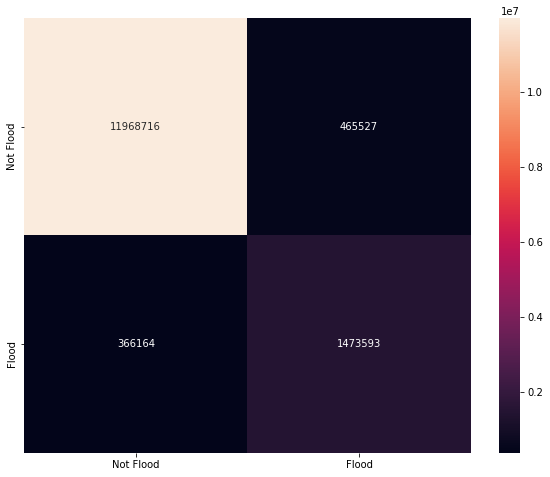

In [31]:
# Confusion Matrix
df_cm = pd.DataFrame(cf_matrix, index = ['Not Flood', 'Flood'], columns = ['Not Flood', 'Flood'])

plt.figure(figsize=(10, 8))
sns.heatmap(df_cm, annot=True, fmt='d')
plt.show()

In [32]:
clf.save_model('bihar_flood_model.txt')

## Loading Saved Model

In [33]:
bst = lgb.Booster(model_file='bihar_flood_model.txt')

In [34]:
pred = bst.predict(X_test)


pred = pred.round(0)

#converting from float to integer
pred=pred.astype(int)

In [35]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97  12434243
           1       0.76      0.80      0.78   1839757

    accuracy                           0.94  14274000
   macro avg       0.87      0.88      0.87  14274000
weighted avg       0.94      0.94      0.94  14274000



In [36]:
f_pred = bst.predict(X)

In [37]:
f_pred = f_pred.round(0)

#converting from float to integer
f_pred= f_pred.astype(int)

In [38]:
print(classification_report(y, f_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97  49736972
           1       0.76      0.80      0.78   7359028

    accuracy                           0.94  57096000
   macro avg       0.87      0.88      0.87  57096000
weighted avg       0.94      0.94      0.94  57096000



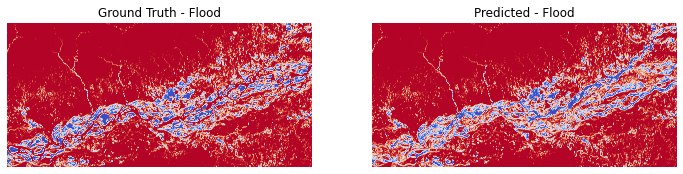

In [40]:
fig = plt.figure(figsize=(12, 20))
ax= fig.subplots(nrows=1, ncols=2, sharex=True, sharey=True)
ax[0].imshow(y.reshape(sz), cmap='coolwarm_r')
ax[0].set_axis_off()
ax[0].title.set_text('Ground Truth - Flood')
ax[1].imshow(f_pred.reshape(sz), cmap='coolwarm_r')
ax[1].title.set_text('Predicted - Flood')
ax[1].set_axis_off()
plt.show()

In [41]:
# final Image
f_img = gt.reshape(gt.shape[1:])
f_img[x1:x2, y1:y2] = f_pred.reshape(sz)


In [42]:
f_img.shape

(10980, 10980)

Predicted Flood Shape:  (10980, 10980)


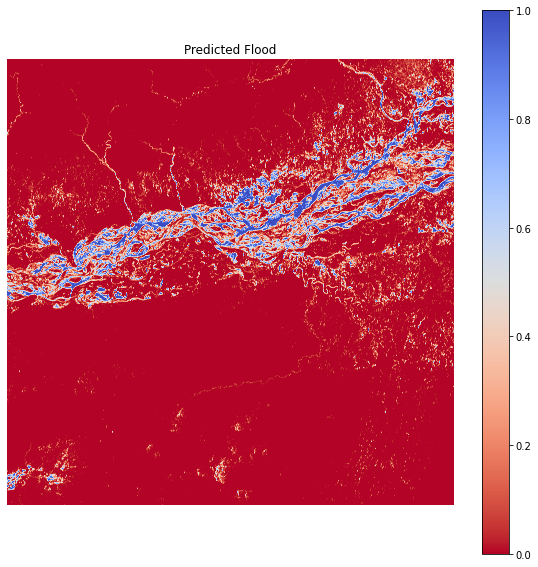

In [43]:
show_band(f_img, title='Predicted Flood', size=(10,10), cmap='coolwarm_r')